# Statistics coded: 

Objective of this notebook is illustrating the "Statistics Explained" article.
Each step in the code is explained by commands over the cells.

"Statistics Explained" in general: 
"https://ec.europa.eu/eurostat/statistics-explained/index.php/Main_Page"

Article: 
#### Tourism Statistics "https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Tourism_statistics"

Prepared by:
#### Sarah Hadj Hassen.

#### Start:
If necessary install the following packages and load them afterwards.

In [ ]:
# install.packages(c("ggplot2", "plotly", "tidyr", "repr", "dplyr", "devtools", "restatapi", "eurostat", 
#                    "patchwork", "Matching", "ggforce", "h2o", "plyr"))

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(eurostat)
library(Matching)
library(stats)
library(base)
library(ggforce)
library(h2o)
library(plyr)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'eurostat' was built under R version 3.6.3"Warning message:
"package 'Matching' was built under R version 3.6.3"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

## 
##  Matching (Version 4.9-7, Build Date: 2020-02-05)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statist

## Tourism destinations - nights spent at tourist accomodation establishments, 2018

### Create graph in abstract

#### First step:
- load the needed data: `data`
- we just need the data for 2018, therefore we add a column, which indicates only the year - we will do this for each subsequent datset
- create a vector with all needed countries: `countr`

In [3]:
data <- get_eurostat(id="tour_occ_ninat") 

data$year <- as.integer(substr(data$time,1,4))

countr <- c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","PL","IE","CY","SE","HU","DK","SI",
            "MT","FI","SK","RO","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME","RS","MK","XK")

Table tour_occ_ninat cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/tour_occ_ninat_date_code_TF.rds


For Ireland, Slovenia, United Kingdom, Switzerland, Norway, Iceland, Montenegro, Serbia and Kosovo we need 2018 monthly data.
- therefore we need another dataset and have to load it: `data_month`
- add a column, which indicates only the year and one with the month
- create a vector, which includes only the countries mentioned above: `countr_fig0`

In [4]:
data_month <- get_eurostat(id="tour_occ_nim")

data_month$year <- as.integer(substr(data_month$time,1,4))
data_month$month <- as.integer(substr(data_month$time,6,7))

countr_fig0 <- c("IE","SI","UK","CH","NO","IS","ME","RS","XK")

Table tour_occ_nim cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/tour_occ_nim_date_code_TF.rds


- build the subset, which we need for the graph: `data_mod`
- because we have monthly data - but need yearly data - we have to aggregate the data per country
- name the second column 

In [5]:
data_mod <- subset(data_month, 
                    data_month$geo %in% countr_fig0 & #include just the countries of the vector above
                    data_month$year==2018 & #only values for 2018
                    data_month$c_resid=="FOR" & #just non-residents
                    data_month$nace_r2=="I551-I553"& #the classification we need
                    data_month$unit=="NR") #we need the unit "number"

data_mod <- aggregate(data_mod$values, by = list(geo = data_mod$geo), FUN = sum)

names(data_mod)[2] <- "values"

Build needed subset for the other countries (same like above with the dataset `data`): `data_mod2`
- we only need column 4 and 6 for the following analysis

In [6]:
data_mod2 <- subset(data, 
                    data$geo %in% countr & 
                    data$year==2018 &
                    data$c_resid=="FOR" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")

data_mod2 <- data_mod2[,c(4,6)]

For Turkey (`countr_fig0_1`) we need data from 2016. Build subset `data_mod3`

In [7]:
countr_fig0_1 <- c("TR")

data_mod3 <- subset(data, 
                    data$geo %in% countr_fig0_1 & 
                    data$year==2016 & 
                    data$c_resid=="FOR" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")

data_mod3 <- data_mod3[,c(4,6)] 

#### Second step:
Match `data_mod1` and `data_mod2` and `data_mod3`
- i.e. use rbind to stick the data frames together - we get the final dataset for the graph: `data_mod4`

Bring the country names in the order the graphik shows: you can do this due to modify the levels of the variable "geo"

In [8]:
data_mod4 <- rbind(data_mod,data_mod2,data_mod3)

In [9]:
data_mod4$geo <- factor(data_mod4$geo,
                        levels = c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","PL","IE","CY","SE","HU",
                                   "DK","SI", "MT","FI","SK","RO","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME",
                                   "RS","MK","XK"))

head(data_mod4)

,geo,values
,<fct>,<dbl>
1,NO,10138183
2,CH,26720046
3,IS,7446807
4,RS,3656787
5,SI,11159025
6,UK,140385998


#### Third step:
Finally use the modified dataset `data_mod4` and build the graph by using ggplot.

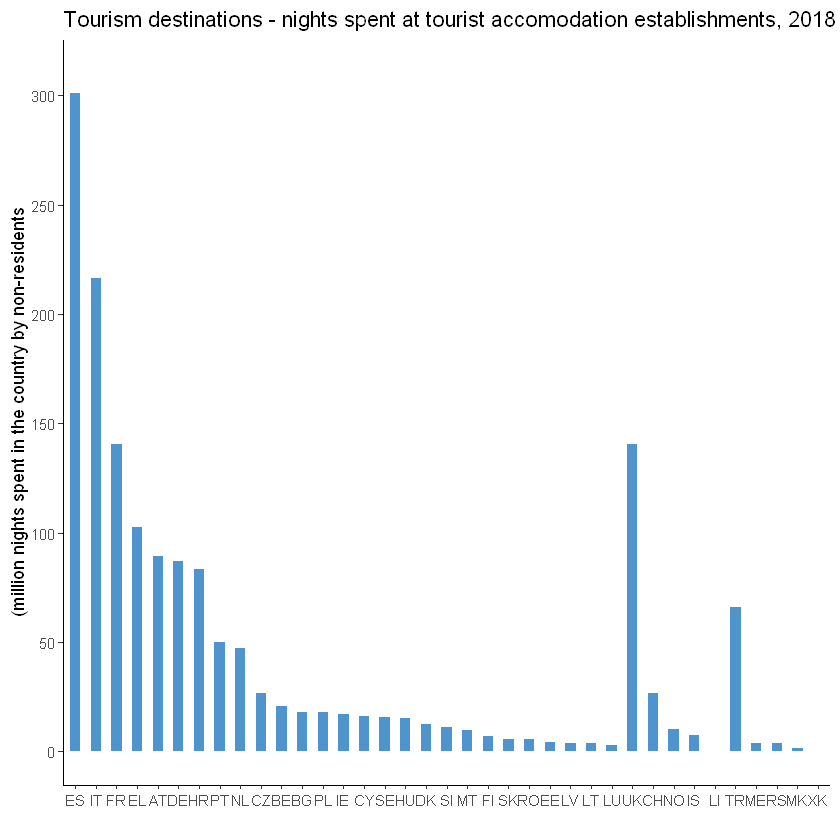

In [10]:
options(scipen=999) #prevent scientific notation
label_axes1 <- seq(0, 300, by = 50) #we need this later to label the axes

ggplot(data_mod4, #needed dataset
       aes(x=geo,y=values)) + #the axes you want
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") + #for creating a bar chart
            theme_classic() +
            scale_y_continuous(limits = c(0, 310000000), breaks = seq(0, 300000000, by = 50000000), #limit the axes
                              labels=label_axes1) + #label the axes
            ggtitle("Tourism destinations - nights spent at tourist accomodation establishments, 2018") +
            ylab("(million nights spent in the country by non-residents") + #name the axes
            xlab(" ")

## Bed places in the EU-27: Italy and France predominate


### Create table 1

We need 3 datasets - one for each column.
- create a countries vector - the countries are already in the same order the table shows: `countr_0`

In [58]:
countr_0 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
              "AT","PL","PT","RO","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")

#### First step:
column 1: number of establishments (units)
- load the needed data and add the year-column: `data_1`
- exclude the countries from the country-vector, which need data from 2016 and 2017: `countr_tab1`

In [12]:
data_1 <- get_eurostat(id="tour_cap_nat")
data_1$year <- as.integer(substr(data_1$time,1,4))

countr_tab1 <- c("BE","BG","CZ","DK","DE","EE","EL","ES","FR","HR","IT","CY","LV","LT","HU","MT","NL",
              "AT","PL","PT","RO","SK","FI","SE","IS","LI","NO","CH","ME","MK","RS")

Table tour_cap_nat cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/tour_cap_nat_date_code_TF.rds


Build the subset we need for the first column of the table and choose column 4 and 6 again: `data_tab1`

In [13]:
data_tab1 <- subset(data_1, 
                    data_1$geo %in% countr_tab1 & 
                    data_1$year==2018 &
                    data_1$nace_r2=="I551-I553"&
                    data_1$unit=="NR"&
                    data_1$accommod=="ESTBL")
data_tab1 <- data_tab1[,c(4,6)]

For Ireland and United Kingdom (`countr_tab1_1`) we need data from 2016. Build the subset: `data_tab1_1`

In [14]:
countr_tab1_1 <- c("IE","UK")
data_tab1_1 <- subset(data_1, 
                      data_1$geo %in% countr_tab1_1 & 
                      data_1$year==2016 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="ESTBL")
data_tab1_1 <- data_tab1_1[,c(4,6)]

For Luxembourg, Slovenia and Kosovo (`countr_tab1_2`) we need data from 2017. Build the subset: `data_tab1_2`

In [15]:
countr_tab1_2 <- c("LU","SI","XK")
data_tab1_2 <- subset(data_1, 
                      data_1$geo %in% countr_tab1_2 & 
                      data_1$year==2017 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="ESTBL")
data_tab1_2 <- data_tab1_2[,c(4,6)]

For Turkey we have NA. Assign to `data_tab1_3`

In [16]:
data_tab1_3 <- data.frame( geo = "TR", values=  NA)

Match the three calculated datasets to `data_tab_col1` and bring the country names in the order the grpahik shows

In [17]:
data_tab_col1 <- rbind(data_tab1,data_tab1_1,data_tab1_2,data_tab1_3)

data_tab_col1 <- data_tab_col1[order(factor(data_tab_col1$geo, levels= countr_0)),]

head(data_tab_col1)

geo,values
<fct>,<dbl>
BE,9211
BG,3458
CZ,9426
DK,1167
DE,50020
EE,1535


#### Second step:

column 2: number of bed places (thousands)
- exclude the countries, which need data from 2016 and 2017: `countr_tab2`
- build the subset and choose again column 4 and 6: `data_tab2`

In [18]:
countr_tab2 <- c("BE","BG","CZ","DK","DE","EE","EL","ES","FR","HR","IT","CY","LV","LT","HU","MT","NL",
              "AT","PL","PT","RO","SK","FI","SE","IS","LI","NO","CH","ME","MK","RS","TR")
data_tab2 <- subset(data_1, 
                    data_1$geo %in% countr_tab2 & 
                    data_1$year==2018 &
                    data_1$nace_r2=="I551-I553"&
                    data_1$unit=="NR"&
                    data_1$accommod=="BEDPL")
data_tab2 <- data_tab2[,c(4,6)]

For Ireland and United Kingdom (`countr_tab2_1`) we need data from 2016. Build the subset: `data_tab2_1`

In [19]:
countr_tab2_1 <- c("IE","UK")
data_tab2_1 <- subset(data_1, 
                      data_1$geo %in% countr_tab2_1 & 
                      data_1$year==2016 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="BEDPL")
data_tab2_1 <- data_tab2_1[,c(4,6)]

For Luxembourg, Slovenia and Kosovo (`countr_tab2_2`) we need data from 2017. Build the subset: `data_tab2_2`

In [20]:
countr_tab2_2 <- c("LU","SI","XK")
data_tab2_2 <- subset(data_1, 
                      data_1$geo %in% countr_tab2_2 & 
                      data_1$year==2017 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="BEDPL")
data_tab2_2 <- data_tab2_2[,c(4,6)]

For Turkey we have NA. Assign to `data_tab2_3`

In [21]:
data_tab2_3 <- data.frame( geo = "TR", values=  NA)

Match the three calculated datasets to `data_tab_col2` and bring the country names in the order the graph shows

In [22]:
data_tab_col2 <- rbind(data_tab2,data_tab2_1,data_tab2_2,data_tab2_3)

data_tab_col2 <- data_tab_col2[order(factor(data_tab_col2$geo, levels= countr_0)),]

head(data_tab_col2)

geo,values
<fct>,<dbl>
BE,389826
BG,335597
CZ,741235
DK,426075
DE,3473630
EE,61193


#### Third step:
column 3: nights spent by residents and non-residents (millions)
- exclude the countries, which need monthly data and data from 2016: `countr_tab3`
- we already load the data (`data`) for a graph before. Build the subset: `data_tab3`

In [23]:
countr_tab3 <- c("BE","BG","CZ","DK","DE","EE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                 "AT","PL","PT","RO","SK","FI","SE","LI","MK","TR")

data_tab3 <- subset(data, 
                    data$geo %in% countr_tab3 & 
                    data$year==2018 &
                    data$c_resid=="TOTAL" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")
data_tab3 <- data_tab3[,c(4,6)]

For Ireland, Slovenia, United Kingdom, Switzerland, Norway, Iceland, Montenegro, Serbia and Kosovo (`countr_tab3_1`) we need 2018 monthly data
- we already load the data (`data_month`) for a graph before. Build the subset: `data_tab3_1`
- because we have monthly data - but need yearly data - we have to aggregate the data per country
- name the second column 

In [24]:
countr_tab3_1 <- c("IE","SI","UK","CH","NO","IS","ME","RS","XK")

data_tab3_1 <- subset(data_month, 
                    data_month$geo %in% countr_tab3_1 & 
                    data_month$year==2018 &
                    data_month$c_resid=="TOTAL" &
                    data_month$nace_r2=="I551-I553"&
                    data_month$unit=="NR")
data_tab3_1 <- aggregate(data_tab3_1$values, by = list(geo = data_tab3_1$geo), FUN = sum)
names(data_tab3_1)[2] <- "values"

For Turkey (`countr_tab3_2`) we need data from 2016. Build the subset: `data_tab3_2`

In [25]:
countr_tab3_2 <- c("TR")

data_tab3_2 <- subset(data, 
                      data$geo %in% countr_tab3_2 & 
                      data$year==2016 &
                      data$c_resid=="TOTAL" &
                      data$nace_r2=="I551-I553"&
                      data$unit=="NR")
data_tab3_2 <- data_tab3_2[,c(4,6)]

Match the three calculated datasets to `data_tab_col3` and bring the country names in the order the grpahik shows

In [49]:
data_tab_col3 <- rbind(data_tab3,data_tab3_1,data_tab3_2)

data_tab_col3 <- data_tab_col3[order(factor(data_tab_col3$geo, levels= countr_0)),]

head(data_tab_col3)

geo,values
<fct>,<dbl>
BE,41320284
BG,26845013
CZ,55513922
DK,33280395
DE,419556284
EE,6630315


#### Forth step:
- create a column with the names of the countries: `countr_names`
- match all columns together to create the data for the final table: `table`

In [27]:
countr_names <- c("Belgium","Bulgaria","Czechia","Denmark","Germany","Estonia", "Ireland", "Greece", "Spain", "France", 
                  "Croatia", "Italy", "Cyprus", "Latvia", "Lithuania", "Luxembourg", "Hungary", "Malta", "Netherlands", 
                  "Austria", "Poland", "Portugal", "Romania", "Slovenia", "Slovakia", "Finland", "Sweden",
                 "United Kingdom", "Iceland", "Liechtenstein", "Norway", "Switzerland", "Montenegro", "North Macedonia", 
                  "Serbia", "Turkey", "Kosovo")

table <- cbind(countr_names, data_tab_col1[,2], data_tab_col2[,2], data_tab_col3[,2])

head(table)

,countr_names,values,values,values
,<fct>,<dbl>,<dbl>,<dbl>
1,Belgium,9211,389826,41320284
2,Bulgaria,3458,335597,26845013
3,Czechia,9426,741235,55513922
4,Denmark,1167,426075,33280395
5,Germany,50020,3473630,419556284
6,Estonia,1535,61193,6630315


#### Fifth step:
Calculate the EU-27 value by summing up
- first we create the vector with the 27 countries, we will use this vector in other graphics, too: `EU_27`

In [28]:
EU_27 <- c("AT","BE", "BG","HR","CY", "CZ","DK", "DE", "EE","FI","FR","EL","HU","IE",
           "IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE")

- We need the `table` from above (the three columns) with shortcuts instead of full names to exclude the not-EU countries: `tab_prep`
    - do this by using the `EU_27` vector
    - therefore we add the `countr_0` vector, which we create in the first step
- then create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of `countr_0` are within EU_27: `EU_27_prep`
- by using the sapply-command we can calculate the sum for each column of the table `table`

In [151]:
tab_prep <- cbind(countr_0,data_tab_col1[,2], data_tab_col2[,2], data_tab_col3[,2])

EU_27_prep <- tab_prep$countr_0 %in% EU_27

tab_EU <- c("EU-27",sapply(table[EU_27_prep,2:4],sum))                

- put the summarized values to the calculated `table` from above: `table_final`
    - at this stage we get the warning message, that one NA for "EU-27" get generated: we solve this problem two steps later
- give the columns the correct names
- we have to convert the class, because we have to add "EU-27" and this only works by converting it from a factor first, then doing the change and re-convert it back
- we want to modify the numbers: second column in thousands and third columns in millions

In [156]:
table_final <- rbind(tab_EU,table)

names(table_final) <- c("", "Number of establishments (units)", "Number of bed places (thousands)",
                       "Nights spent by residents and non-residents (millions)")

table_final[,1] <- as.character(table_final[,1])
table_final[1,1] <- "EU-27"
table_final[,1] <- factor(table_final[,1])

table_final[,3] <- round(as.numeric(table_final[,3])/ 1000,0)
table_final[,4] <- round(as.numeric(table_final[,4])/ 1000000,1)

as.matrix(table_final)

Warning message in `[<-.factor`(`*tmp*`, ri, value = "EU-27"):
"invalid factor level, NA generated"

,Number of establishments (units),Number of bed places (thousands),Nights spent by residents and non-residents (millions)
EU-27,600157,28294,2791.2
Belgium,9211,390,41.3
Bulgaria,3458,336,26.8
Czechia,9426,741,55.5
Denmark,1167,426,33.3
Germany,50020,3474,419.6
Estonia,1535,61,6.6
Ireland,3145,200,33.4
Greece,38180,1340,123.1
Spain,51418,3600,466.9


## Nights spent by non-residents in the EU-27: Spain on top

### create figure 1

#### First step:
- choose the countries from the EU 2020 and build the country vector like we did above: `EU_27`
- we already load the data (`data`) for the first graph we create

In [32]:
EU_27 <- c("AT","BE", "BG","HR","CY", "CZ","DK", "DE", "EE","FI","FR","EL","HU","IE",
           "IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE")

Build a loop for getting the data for the three lines
- we have to create a vector with the essential difference between the three columns: `night`
- create an empty data frame, which we can fill while running the loop: `data_fig1_final`
- when we look at the data `data`, we see that there are some years without datapoints, therefore we can omit them
- for every year we have data from the 27 EU-countries - we just need one aggregate value for every year
- assign the calculated data `data_fig1` in each intermediate step to the empty data frame

In [149]:
night <- c("FOR","NAT","TOTAL")

data_fig1_final <- list(year = c(2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005),
                                 FOR = matrix(ncol=2, nrow=14),
                                 NAT = matrix(ncol=2, nrow=14),
                                TOTAL = matrix(ncol=2, nrow=14))
# build the loop
for (i in 1:3) {

data_fig1 <- subset(data, 
                    data$geo %in% EU_27 & 
                    data$year %in% c(2005,2006, 2007, 2008,2009,2010,2011,2012, 2013,2014,2015,2016,2017,2018) &
                    data$c_resid== night[i] & #here we have the essential difference between the columns we create
                    data$unit=="NR" &
                    data$nace_r2=="I551-I553") 

data_fig1 <- aggregate(data_fig1$values, by = list(year = data_fig1$year), FUN = sum) 
    
# print(data_fig1) #if you want to see the intermediate steps

data_fig1_final[[i+1]] <- data_fig1 
    
 }

data_fig1_final <- as.data.frame(data_fig1_final)
data_fig1_final <- data_fig1_final[,c(2,3,5,7)] #attention! the first year-column is wrongly in an decreasing order!
data_fig1_final <- data_fig1_final[order(data_fig1_final[,1]),]
head(data_fig1_final)

,FOR.year,FOR.x,NAT.x,TOTAL.x
,<int>,<dbl>,<dbl>,<dbl>
1,2005,861934580,1143692910,2005627490
2,2006,897421835,1178407554,2075829389
3,2007,923129509,1167029322,2090158831
4,2008,917291027,1168537632,2085828659
5,2009,865984766,1161870294,2027855060
6,2010,921187045,1240792245,2161979290


#### Second step:
Now we have to calculate the changes from year to year 
- index: 2005=100: `index`
- create an empty data frame, which we can fill while running the loop: `data_fig1_final_perc`
- we take the values for 2005 as reference value. Each value from the subsequent years should be devided by the reference value from 2005. We have to multiply the result by 100 to achieve, that we start in 2005 with the value 100.

In [215]:
index <- data_fig1_final[1,2:4]

data_fig1_final_perc <- as.data.frame(matrix(ncol=4, nrow=14))

for (i in 1:14) {
data_fig1_final_perc[i,2:4] <- (data_fig1_final[i,2:4]/index)*100 }

data_fig1_final_perc$V1 <- c(2005,2006, 2007, 2008,2009,2010,2011,2012, 2013,2014,2015,2016,2017,2018)
head(data_fig1_final_perc)

,V1,V2,V3,V4
,<dbl>,<dbl>,<dbl>,<dbl>
1,2005,100.0000,100.0000,100.0000
2,2006,104.1172,103.0353,103.5002
3,2007,107.0997,102.0404,104.2147
4,2008,106.4223,102.1723,103.9988
5,2009,100.4699,101.5894,101.1083
6,2010,106.8744,108.4900,107.7957


#### Thrid step:
Finally use the modified dataset `data_fig1_final_perc` and build the graph by using ggplot

Warning message:
"Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?"

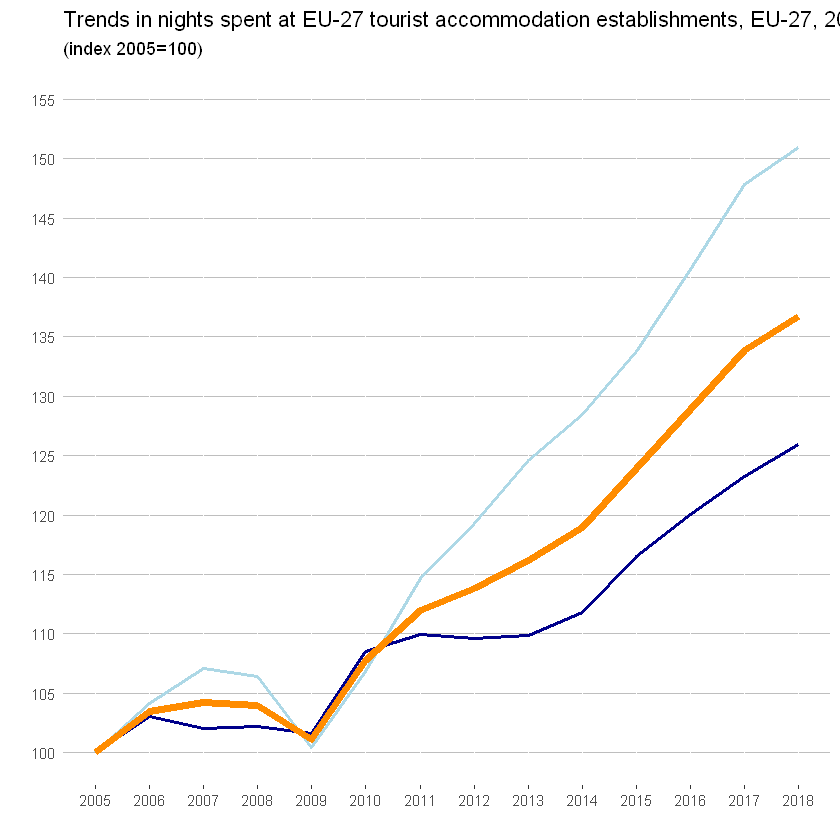

In [40]:
ggplot(data_fig1_final_perc,aes(x=V1)) + 
  geom_line(aes(y=V2, group=1, color="line"), color="lightblue", size=1) + #we add three lines
  geom_line(aes(y=V3, group=1, color="line"), color="darkblue", size=1) +
  geom_line(aes(y=V4, group=1, color="line"), color="darkorange", size=2) +
    ggtitle("Trends in nights spent at EU-27 tourist accommodation establishments, EU-27, 2005-2018",
        subtitle="(index 2005=100)") +
    scale_y_continuous(limits = c(100, 155), breaks = seq(100, 155, by = 5)) +
    scale_x_discrete(limits = c(2005,2006, 2007, 2008,2009,2010,2011,2012, 2013,2014,2015,2016,2017,2018)) +
    ylab(" ") +
    xlab(" ") +
    theme(panel.grid.major.y = element_line(color="grey"),
          panel.background = element_rect(fill = NA),
          axis.ticks.y = element_line(colour= "white"))

### create figure 2

It's in principal the same graph like in the abstract part. Check the code there.

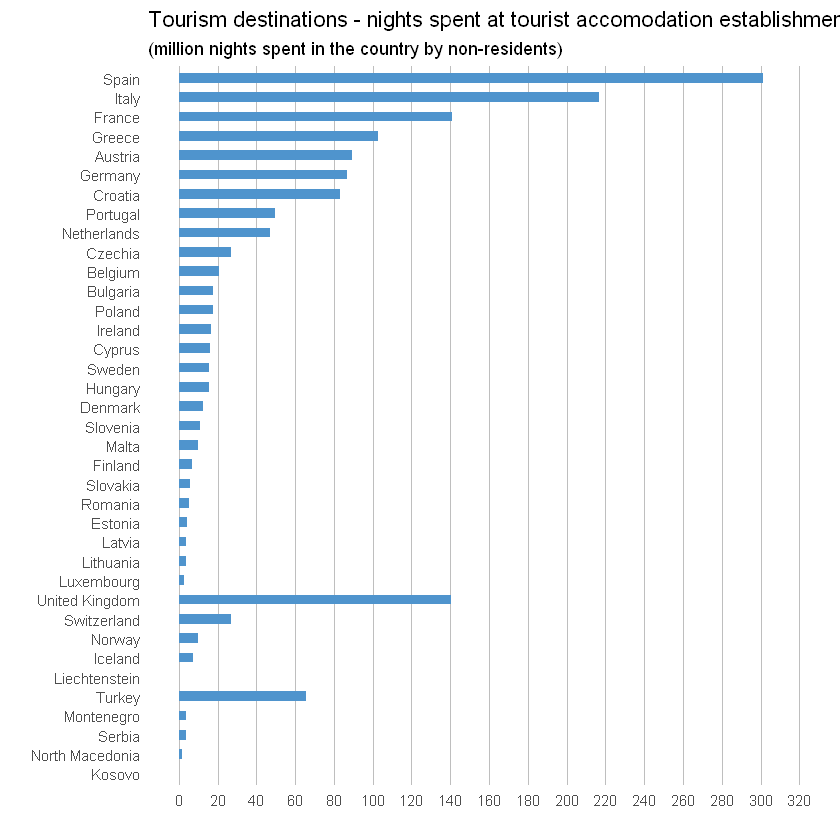

In [41]:
label_axes2 <- seq(0, 320, by = 20)

ggplot(data_mod4, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            scale_y_continuous(limits = c(0, 320000000), breaks = seq(0, 320000000, by = 20000000),
                              labels=label_axes2) +
            ggtitle("Tourism destinations - nights spent at tourist accomodation establishments, 2018",
                   subtitle = "(million nights spent in the country by non-residents)") +
            coord_flip() +
            scale_x_discrete(limits = rev(levels(data_mod4$geo)),
                             labels = c("Kosovo", "North Macedonia", "Serbia", "Montenegro", "Turkey", "Liechtenstein", 
                                        "Iceland", "Norway", "Switzerland", "United Kingdom", "Luxembourg", "Lithuania", 
                                        "Latvia", "Estonia", "Romania", "Slovakia", "Finland", "Malta", "Slovenia", 
                                        "Denmark", "Hungary", "Sweden", "Cyprus", "Ireland", "Poland", "Bulgaria", 
                                        "Belgium", "Czechia", "Netherlands", "Portugal", "Croatia", "Germany", "Austria", 
                                        "Greece", "France", "Italy", "Spain")) +
            ylab(" ") +
            xlab(" ") +
            theme(panel.grid.major.x = element_line(color="grey"),
                  panel.background = element_rect(fill = NA),
                  axis.line = element_line(colour = "white"),
                  axis.ticks = element_line(colour= "white"))

## create figure 3

#### First step:
Calculate the EU-27 value by summing up
- create again a vector, which indicates due to FALSE and TRUE at the exact position, which countries of `countr_0` are within `EU_27`: `EU_27_prep2`
- by using the sapply-command we can calculate the sum for each column of `data_mod4`

In [42]:
EU_27_prep2 <- data_mod4$geo %in% EU_27

tab_EU2 <- sapply(as.data.frame(data_mod4[EU_27_prep2,2]),sum)

Add a column with the ratios we need for the pie chart: `tab_ratio`
- shorten the table through `EU_27_prep2` (countries outside the EU should be delete)
- sort the ratios in a decreasing order
- keep the top 9 countries in `tab_ratio_top9` and summing up the others to "Rest of EU-27" in `tab_ratio_other` by using again the sapply command
- add afterwards the sum in `tab_ratio_other_sum` to the top 9: `tab_ratio_new`

In [43]:
tab_ratio <- cbind(data_mod4,data_mod4[2]/tab_EU2*100)

tab_ratio <- tab_ratio[EU_27_prep2,]

tab_ratio <- tab_ratio[order(tab_ratio[,3], decreasing=T),]

tab_ratio_top9 <- tab_ratio[1:9,]
tab_ratio_other <- tab_ratio[10:27,]
tab_ratio_other_sum <- sapply(as.data.frame(tab_ratio_other[,3]),sum)

tab_ratio_new <- rbind(tab_ratio_top9[,c(1,3)], tab_ratio_other_sum)
tab_ratio_new

Warning message in `[<-.factor`(`*tmp*`, ri, value = 15.9651602486859):
"invalid factor level, NA generated"

,geo,values
,<fct>,<dbl>
19,ES,22.645198
24,IT,16.287560
21,FR,10.586126
18,EL,7.716184
10,AT,6.717353
15,DE,6.541928
22,HR,6.254410
33,PT,3.750269
31,NL,3.535812


#### Second step:
Plot the pie chart 
- first create the labels
    - round the values and put a "%" behind it: `label_pie1`
    - create a vector with the needed country names: `label_pie2`
    - combine the both created label parts: `label_pie3`
- within ggplot we have to create bars first. Afterwards we can convert it to a pie chart

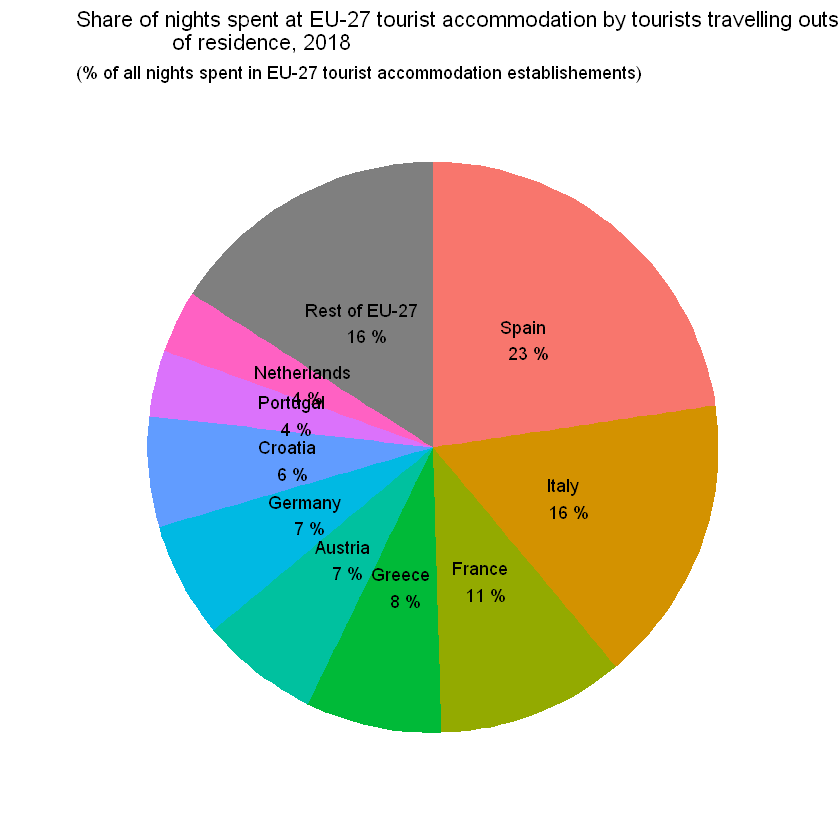

In [220]:
label_pie1 <- paste(round(tab_ratio_new$values,0), "%")
label_pie2 <- c("Spain","Italy","France","Greece","Austria","Germany","Croatia","Portugal","Netherlands","Rest of EU-27")
label_pie3 <- paste(label_pie2,"\n",label_pie1) #we can add "/n" to achieve a line break

ggplot(tab_ratio_new, aes(x="", y=values, fill=geo)) +
       geom_bar(stat = "identity", width=1) + 
       coord_polar("y", direction = -1, start=0) +
       geom_text(label = label_pie3, position = position_stack(vjust = 0.5)) +
       ylab(" ") +
       xlab(" ") +
       ggtitle("Share of nights spent at EU-27 tourist accommodation by tourists travelling outside their own country 
                of residence, 2018",
                subtitle = "(% of all nights spent in EU-27 tourist accommodation establishements)") +
       theme_classic() + 
       theme(legend.position = "none",
             axis.line = element_blank(),
             axis.text = element_blank(),
             axis.ticks = element_blank(),
             panel.grid  = element_blank())

### create figure 4

#### First step:
- we already load the dataset and can therefore use the values from the third colomn of `table_final`
- additionally we need the subsequent dataset: `bev`
- build the needed subset and choose only the relevant columns: `bev_subs`

In [71]:
bev <- get_eurostat(id="demo_gind")

bev_subs <- subset(bev, 
                   bev$geo %in% countr_0 & 
                   bev$indic_de=="AVG" &
                   bev$time=="2018-01-01")
bev_subs <- bev_subs[,c(2,4)]

Reading cache file C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/demo_gind_date_code_TF.rds
Table  demo_gind  read from cache file:  C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/demo_gind_date_code_TF.rds


- bring the country's names in the same order (`countr_0`) like the table above, that we can add the columns with the tourist accomodation
- add the columns with the tourist accomodation from `data_tab_col3` and add the needed ratio-column

In [72]:
bev_subs <- bev_subs[order(factor(bev_subs$geo, levels= countr_0)),]

bev_subs <- cbind(bev_subs,data_tab_col3)

bev_subs <- cbind(bev_subs,bev_subs[,4]/bev_subs[,2])

names(bev_subs)[5] <- "values"
bev_subs <- bev_subs[,c(1,5)]

-  create new country vector `countr_fig4` to bring the countries in the order the graph shows

In [73]:
countr_fig4 <- c("HR", "MT","CY","AT","EL","ES","SI","PT","IT","IE","NL","FR","SE","DK","CZ","DE","EE","LU","FI","BG",
                 "BE","HU","LT","SK","LV","PL","RO", "UK", "IS","CH","NO","LI","ME","TR","RS","MK","XK")

bev_subs <- bev_subs[order(factor(bev_subs$geo, levels= countr_fig4)),]

#### Second step:
Calculate the EU-27 value by summing up 
- create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of bev_subs are within `EU_27`: `EU_27_prep_2_1`
- by using the sapply-command we can calculate the average for the column of the table "bev_subs"
    - at this stage we get the warning message, that one NA for "Eu-27" get generated: we solve this problem two steps later
- put the summarized values to the calculated table from above
- we have to convert the class, because we have to add "EU-27" and this only works by converting it from a factor first, then doing the change and re-convert it back

In [74]:
EU_27_prep_2_1 <- bev_subs$geo %in% EU_27

tab_EU2_1 <- c("EU-27",sapply(as.data.frame(bev_subs[EU_27_prep_2_1,2]),mean))

bev_subs <- rbind(tab_EU2_1,bev_subs)

bev_subs[,1] <- as.character(bev_subs[,1])
bev_subs[1,1] <- "EU-27"
bev_subs[,1] <- factor(bev_subs[,1])

head(bev_subs)

Warning message in `[<-.factor`(`*tmp*`, ri, value = "EU-27"):
"invalid factor level, NA generated"

,geo,values
,<fct>,<chr>
1,EU-27,7.37476857884317
11,HR,21.894524392122
18,MT,20.8699337639024
13,CY,19.7274029156342
20,AT,14.1653608424209
8,EL,11.4682317386886


#### Third step:
Plot the graph via ggplot
- bring the country names in the order the graphik shows: you can do this due to modify the levels of the variable "geo"
- to achieve that the y-axes in the chart is later in an ascending order, we have to convert the ratio-axes to numeric

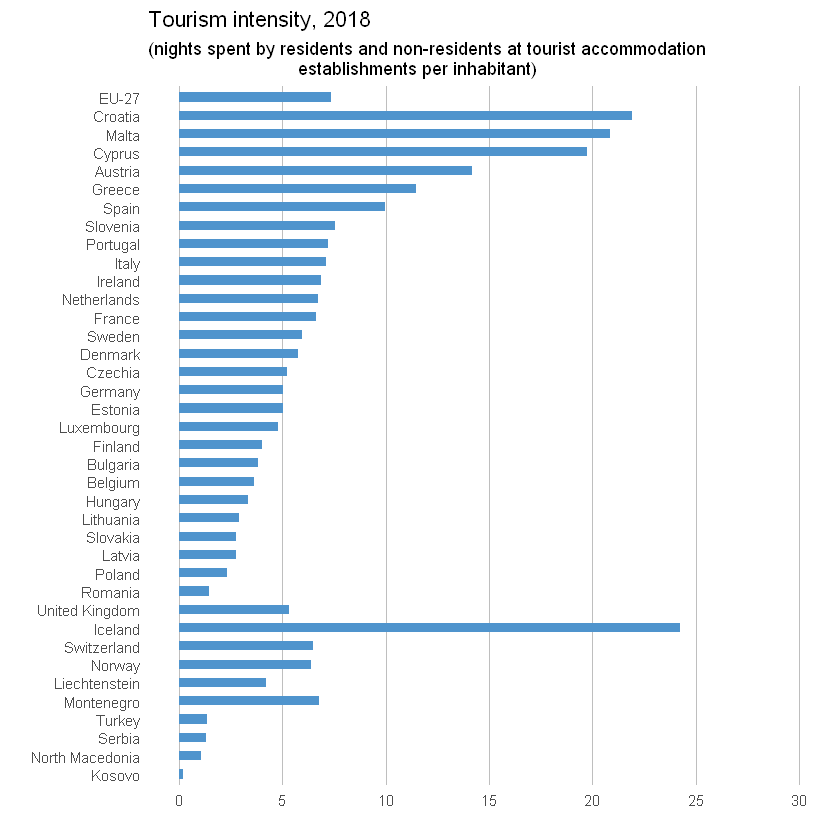

In [76]:
bev_subs$geo <- factor(bev_subs$geo,
                        levels = c("EU-27","HR", "MT","CY","AT","EL","ES","SI","PT","IT","IE","NL","FR","SE","DK","CZ","DE",
                                   "EE","LU","FI","BG","BE","HU","LT","SK","LV","PL","RO", "UK", "IS","CH","NO","LI",
                                   "ME","TR","RS","MK","XK"))

bev_subs$values <- as.numeric(as.character(bev_subs$values))

ggplot(bev_subs, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            scale_y_continuous(limits = c(0, 30), breaks = seq(0, 30, by = 5)) +
            ggtitle("Tourism intensity, 2018",
                   subtitle="(nights spent by residents and non-residents at tourist accommodation 
                              establishments per inhabitant)") +
            coord_flip() +
            scale_x_discrete(limits = rev(levels(bev_subs$geo)),
                             labels = c("Kosovo", "North Macedonia", "Serbia", "Turkey", "Montenegro", "Liechtenstein", 
                                        "Norway", "Switzerland", "Iceland", "United Kingdom", "Romania", "Poland", 
                                        "Latvia", "Slovakia", "Lithuania", "Hungary", "Belgium", "Bulgaria", "Finland", 
                                        "Luxembourg", "Estonia", "Germany", "Czechia", "Denmark", "Sweden", "France", 
                                        "Netherlands", "Ireland", "Italy", "Portugal", "Slovenia", "Spain", "Greece", 
                                        "Austria", "Cyprus", "Malta", "Croatia", "EU-27")) +
            ylab(" ") +
            xlab(" ") +
            theme(panel.grid.major.x = element_line(color="grey"),
                  panel.background = element_rect(fill = NA),
                  axis.line = element_line(colour = "white"),
                  axis.ticks = element_line(colour= "white"))


## Tourism trips: Residents of Luxembourg, Belgium, Malta and Slovenia made more outbound than domestic trips

### create table 2
First we create the table and afterwards figure 5, because it is easier to build the graph with the data from the table

#### First step:
We start with the first three columns, which are based on the same dataset
- load the dataset: `data_2`
- again we add a year-column

In [77]:
data_2 <- get_eurostat(id="tour_dem_tttot")

data_2$year <- as.integer(substr(data_2$time,1,4))

Table tour_dem_tttot cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/tour_dem_tttot_date_code_TF.rds


Build a loop
- due to we want to use a loop for getting the data for the three columns, we have to create a vector with the essential difference between the three columns: `duration_vec`
- create an empty data frame, which we can fill while running the loop: `data_tab2_part1`
    - we have 3 columns in the needed dataset
    - and we have data for 30 countries and therefore 30 rows in the needed dataset

In [78]:
duration_vec <-  c("N_GE1","N1-3","N_GE4")

data_tab2_part1 <- as.data.frame(matrix(ncol = 3, nrow = 30))

Within the loop create several subsets from `data_2`
- first subset `data_2_col1_1`: exclude the countries `countr_tab2_1_1`, which need data from 2017
- second subset `data_2_col1_2`: for Poland and Romania in `countr_tab2_1_2` we need data from 2017
- third subset `data_2_col1_3`: for United Kingdom we have NA
- we match afterwards in `data_tab2_col1` the three calculated subsets in every step within the loop
- then we bring the country names in the order the table shows: we can use the vector `countr_0` from beginning
- we calculate the `data_tab2_col1` three times for each case of duration_vec
    - to look at the three intermediate step we can print it
- last but not least we assign the three intermediate step to the empty data frame `data_tab2_part1` we create before

In [79]:
for (i in 1:3) {

countr_tab2_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PT","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")
data_2_col1_1 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_1 & 
                    data_2$year==2018 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="WORLD")
data_2_col1_1 <- data_2_col1_1[,c(5,7)]

countr_tab2_1_2 <- c("PL","RO")
data_2_col1_2 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_2 & 
                    data_2$year==2017 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="WORLD")
data_2_col1_2  <- data_2_col1_2[,c(5,7)]

data_2_col1_3 <- data.frame( geo = "UK", values=  NA)

data_tab2_col1 <- rbind(data_2_col1_1,data_2_col1_2,data_2_col1_3)

data_tab2_col1 <- data_tab2_col1[order(factor(data_tab2_col1$geo, levels= countr_0)),]

data_tab2_col1$values <- round(data_tab2_col1$values,0)
data_tab2_col1
  
# print(data_tab2_col1) 

data_tab2_part1[,i] <- data_tab2_col1[,2]
    
 }

head(data_tab2_part1)

,V1,V2,V3
,<dbl>,<dbl>,<dbl>
1,16893,7058,9835
2,5090,2748,2343
3,34569,21380,13189
4,18875,10380,8495
5,267879,132289,135591
6,6468,5109,1358


Create a column with the names of the countries (`countr_names2`), this will be the first column of the complete table 2. Add this column to the three calculated columns from above: `table2_vers1`

In [80]:
countr_names2 <- c("Belgium","Bulgaria","Czechia","Denmark","Germany","Estonia", "Ireland", "Greece", "Spain", "France", 
                  "Croatia", "Italy", "Cyprus", "Latvia", "Lithuania", "Luxembourg", "Hungary", "Malta", "Netherlands", 
                  "Austria", "Poland", "Portugal", "Romania", "Slovenia", "Slovakia", "Finland", "Sweden",
                 "United Kingdom", "Norway", "Switzerland")

table2_vers1 <- cbind(countr_names2, data_tab2_part1)
head(table2_vers1)

,countr_names2,V1,V2,V3
,<fct>,<dbl>,<dbl>,<dbl>
1,Belgium,16893,7058,9835
2,Bulgaria,5090,2748,2343
3,Czechia,34569,21380,13189
4,Denmark,18875,10380,8495
5,Germany,267879,132289,135591
6,Estonia,6468,5109,1358


#### Second step:
Continuing with column four and five, which are based on the same dataset like column one to three (`data_2`), but with different arguments.
- due to the different arguments we need another for-loop, but basically we have the same process
- create again a vector with the essential difference between the two columns: `duration_vec2`
- create an empty data frame, which we can fill while running the loop: `data_tab2_part2`

We want to calculate the ratio, also for the EU (this we will do later on).
- we need therefore the sum of the column we will create here
- we will save the two sums in a vector called `EU_tab2_sum1` (first we create the empty vector and assign the sums during the loop)

In [81]:
duration_vec2 <-  c("N1-3","N_GE4")

data_tab2_part2 <- as.data.frame(matrix(ncol = 2, nrow = 30))
 
EU_tab2_sum1 <- as.data.frame(matrix(ncol = 2, nrow = 1))

Within the loop create several subsets
- first subset `data_2_col2_1`: exclude the countries (`countr_tab2_1_1`), which need data from 2017
- for Poland and Romania in `countr_tab2_1_2` we need data from 2017. Assign in `data_2_col2_2`
- for United Kingdom we have NA. Assign in `data_2_col2_3`
- we match afterwards the three calculated subsets in every step within the loop in `data_tab2_col2`
- bring the country names in the order the table shows (we can use the vector `countr_0` from beginning)

Within the loop calculate the ratio for each country and a sum for the EU-value
- create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of data_tab2_col3 are within EU_27: `EU_27_prep_col3`
- by using the sapply-command we can calculate the sum: `tab_EU3_col3`
- build the ratio we need (the column just calculated devided by the first column from above (all trips))
- then we assign the ratios to the empty data frame we create before: `data_tab2_part2`

In [82]:
for (i in 1:2) {

countr_tab2_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PT","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")
data_2_col2_1 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_1 & 
                    data_2$year==2018 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="DOM")
data_2_col2_1 <- data_2_col2_1[,c(5,7)]

countr_tab2_1_2 <- c("PL","RO")
data_2_col2_2 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_2 & 
                    data_2$year==2017 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="DOM")
data_2_col2_2  <- data_2_col2_2[,c(5,7)]

data_2_col2_3 <- data.frame( geo = "UK", values=  NA)
    
data_tab2_col2 <- rbind(data_2_col2_1,data_2_col2_2,data_2_col2_3)

data_tab2_col2 <- data_tab2_col2[order(factor(data_tab2_col2$geo, levels= countr_0)),]
    
data_tab2_col2$values <- round(data_tab2_col2$values,0)

EU_27_prep_col3 <- data_tab2_col2$geo %in% EU_27
 
tab_EU3_col3 <- sapply(data_tab2_col2[EU_27_prep_col3,2],sum)
EU_tab2_sum1[,i] <- tab_EU3_col3
    
data_tab2_part2[,i] <- round(data_tab2_col2[,2]/table2_vers1[,2]*100,1)
    
 }

head(data_tab2_part2)

,V1,V2
,<dbl>,<dbl>
1,15.7,6.8
2,48.0,33.5
3,55.7,23.0
4,44.0,19.2
5,40.0,19.5
6,63.5,4.5


#### Third step:
Continue with column six and seven, which are based on the same data like column four to five, the only difference is the variable "partner".

In [83]:
duration_vec2 <-  c("N1-3","N_GE4")

data_tab2_part3 <- as.data.frame(matrix(ncol = 2, nrow = 30))

EU_tab2_sum2 <- as.data.frame(matrix(ncol = 2, nrow = 1))

In [84]:
for (i in 1:2) {

countr_tab2_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                 "AT","PT","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")
data_2_col3_1 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_1 & 
                    data_2$year==2018 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="OUT") #the only difference to column four and five
data_2_col3_1 <- data_2_col3_1[,c(5,7)]

countr_tab2_1_2 <- c("PL","RO")
data_2_col3_2 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_2 & 
                    data_2$year==2017 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="OUT") #the only difference to column four and five
data_2_col3_2  <- data_2_col3_2[,c(5,7)]

data_2_col3_3 <- data.frame( geo = "UK", values=  NA)
    
data_tab2_col3 <- rbind(data_2_col3_1,data_2_col3_2,data_2_col3_3)

data_tab2_col3 <- data_tab2_col3[order(factor(data_tab2_col3$geo, levels= countr_0)),]
    
data_tab2_col3$values <- round(data_tab2_col3$values,0)

EU_27_prep_col3 <- data_tab2_col3$geo %in% EU_27
tab_EU3_col3 <- sapply(data_tab2_col3[EU_27_prep_col3,2],sum)
EU_tab2_sum2[,i] <- tab_EU3_col3
    
data_tab2_part3[,i] <- round(data_tab2_col3[,2]/table2_vers1[,2]*100,1)
    
 }

head(data_tab2_part3)

,V1,V2
,<dbl>,<dbl>
1,26.1,51.4
2,6.0,12.5
3,6.2,15.2
4,11.0,25.8
5,9.4,31.1
6,15.5,16.5


Match `table2_vers1` with the remaining columns (i.e. column 4-7; `data_tab2_part2`,`data_tab2_part3`) to `table2_vers2`

In [85]:
table2_vers2 <- cbind(table2_vers1, data_tab2_part2, data_tab2_part3)

head(table2_vers2)

,countr_names2,V1,V2,V3,V1,V2,V1,V2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Belgium,16893,7058,9835,15.7,6.8,26.1,51.4
2,Bulgaria,5090,2748,2343,48.0,33.5,6.0,12.5
3,Czechia,34569,21380,13189,55.7,23.0,6.2,15.2
4,Denmark,18875,10380,8495,44.0,19.2,11.0,25.8
5,Germany,267879,132289,135591,40.0,19.5,9.4,31.1
6,Estonia,6468,5109,1358,63.5,4.5,15.5,16.5


#### Fourth step:
Now we add the last column, which has another dataset `data_3`
- load the dataset first
- again we add a year-column

In [86]:
data_3 <- get_eurostat(id="tour_dem_totot")

data_3$year <- as.integer(substr(data_3$time,1,4))

Table tour_dem_totot cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/tour_dem_totot_date_code_TF.rds


Exclude the countries, which need data from 2016 and 2017 (`countr_tab2_2_1`). Build the subset `data_2_col4_1`

In [87]:
countr_tab2_2_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LT","LU","HU","MT","NL",
                     "PL","PT","RO","SI","SK","FI","SE","IS","LI","NO","CH","ME","RS","TR")
data_2_col4_1 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_1 & 
                    data_3$year==2018 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_1 <- data_2_col4_1[,c(4,6)]

For United Kingdom (`countr_tab2_2_2`) we need data from 2016. Build the subset `data_2_col4_2`

In [88]:
countr_tab2_2_2 <- c("UK")
data_2_col4_2 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_2 & 
                    data_3$year==2016 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_2 <- data_2_col4_2[,c(4,6)]

For Austria and Latvia (`countr_tab2_2_3`) we need data from 2017. Build the subset `data_2_col4_3`

In [89]:
countr_tab2_2_3 <- c("LV","AT")
data_2_col4_3 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_3 & 
                    data_3$year==2017 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_3 <- data_2_col4_3[,c(4,6)]

- match the subsets to `data_tab2_part4`
- bring the country names in the order the table shows (use `countr_0`)

- here we can keep the country shortcuts, because we need them to calculate the EU-value later 
- by matching the last column to `table2_vers2`, we can delete the shortcut column, because we need the full names here: `table2_vers3`

In [221]:
data_tab2_part4 <- rbind(data_2_col4_1, data_2_col4_2, data_2_col4_3)

data_tab2_part4 <- data_tab2_part4[order(factor(data_tab2_part4$geo, levels= countr_0)),]

data_tab2_part4$values <- round(data_tab2_part4$values, 1)

table2_vers3 <- cbind(table2_vers2, data_tab2_part4[,2])

head(table2_vers3)

,countr_names2,V1,V2,V3,V1,V2,V1,V2,values
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Belgium,16893,7058,9835,15.7,6.8,26.1,51.4,67.7
2,Bulgaria,5090,2748,2343,48.0,33.5,6.0,12.5,33.8
3,Czechia,34569,21380,13189,55.7,23.0,6.2,15.2,78.1
4,Denmark,18875,10380,8495,44.0,19.2,11.0,25.8,69.9
5,Germany,267879,132289,135591,40.0,19.5,9.4,31.1,75.3
6,Estonia,6468,5109,1358,63.5,4.5,15.5,16.5,79.5


#### Fifth step:
Calculate the EU value
- we need one time again the table `table2_vers3` with shortcuts instead of full names to exclude the not-EU countries by using the `EU_27` vector.
- remember that by calculating the last column to `table2_vers3` we keeped the shortcuts for the countries: "data_tab2_part4[,1]" --> this are the shortcuts
- add this to `table2_vers3`

In [91]:
tab_prep3 <- cbind(data_tab2_part4[,1], table2_vers3[,2:9])

- which countries of `tab_prep3` are within `EU_27`: `EU_27_prep3`
- by using the sapply-command we can calculate the sum of the column one to three of the table `table2_vers3`: `tab_EU3_1`

In [92]:
EU_27_prep3 <- tab_prep3$geo %in% EU_27

tab_EU3_1 <- sapply(table2_vers3[EU_27_prep3,2:4],sum)

- for column four to seven we have to calculate the ratio
- we already calculated the sum above: `EU_tab2_sum1` and `EU_tab2_sum2`
- we have to devide this to the sum of "all trips": "tab_EU3_1[1]"
- for the last column we have to take the average, because there is no suitable data in the dataset

In [93]:
tab_EU3_2 <- round(EU_tab2_sum1/tab_EU3_1[1]*100,1)
tab_EU3_3 <- round(EU_tab2_sum2/tab_EU3_1[1]*100,1)

tab_EU3_4 <- round(mean(table2_vers3[EU_27_prep3,9]),1)

Match all EU-values in `tab_EU3`
- at this stage we get the warning message, that one NA for "EU-27" get generated: we solve this problem two steps later
- put the summarized values to the calculated table from above: `table2_final`
- give the columns the correct names

In [94]:
tab_EU3 <- as.numeric(c("EU-27", tab_EU3_1, tab_EU3_2, tab_EU3_3, tab_EU3_4))

table2_final <- rbind(tab_EU3,table2_vers3)

names(table2_final) <- c("",
                        "All trips", 
                        "Short trips (1-3 nights)",
                        "Long trips (4+ nights)",
                        "Short domestic trips (1-3 nights)",
                        "Long domestic trips (4+ nights)",
                        "Short outbound trips (1-3 nights)",
                        "Long outbound trips (4+ nights)",
                        "Share of the population (aged 15+) taking part in tourism trips for personal purposes (%)")

Warning message in base::as.numeric(x):
"NAs durch Umwandlung erzeugt"

- we have to convert the class, because we have to add "EU-27" and this only works by converting it from a factor first, then doing the change and re-convert it back

In [157]:
table2_final[,1] <- as.character(table2_final[,1])
table2_final[1,1] <- "EU-27"
table2_final[,1] <- factor(table2_final[,1])

as.matrix(table2_final)

,All trips,Short trips (1-3 nights),Long trips (4+ nights),Short domestic trips (1-3 nights),Long domestic trips (4+ nights),Short outbound trips (1-3 nights),Long outbound trips (4+ nights),Share of the population (aged 15+) taking part in tourism trips for personal purposes (%)
EU-27,1130622,619562,511063,46.0,24.5,8.8,20.7,65.1
Belgium,16893,7058,9835,15.7,6.8,26.1,51.4,67.7
Bulgaria,5090,2748,2343,48.0,33.5,6.0,12.5,33.8
Czechia,34569,21380,13189,55.7,23.0,6.2,15.2,78.1
Denmark,18875,10380,8495,44.0,19.2,11.0,25.8,69.9
Germany,267879,132289,135591,40.0,19.5,9.4,31.1,75.3
Estonia,6468,5109,1358,63.5,4.5,15.5,16.5,79.5
Ireland,15941,10110,5831,45.9,8.0,17.5,28.6,74.7
Greece,6565,1834,4731,25.0,61.7,2.9,10.4,42.8
Spain,156370,110284,46086,66.9,22.6,3.6,6.9,67.4


## Tourism participation: More than nine out of ten residents of Finland participated in tourism

### create figure 5

#### First step:
We calculated the needed data already for `table2_final` (last column)
- but Albania and North Mazedonia are missing and we have to do the same analysis like above for the both countries 

In [96]:
countr_tab2_2_4 <- c("AL","MK")
data_2_col4_4 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_4 & 
                    data_3$year==2018 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_4 <- data_2_col4_4[,c(4,6)]

- Bring the column from the table above in the order, the graph shows. We create therefore a new country vector `countr_fig5`
- Match the EU-value "tab_EU3[9]", the ordered column from above `data_tab2_part4.1` and the two additional countries `data_2_col4_4` in `data_tab2_part5`

In [97]:
countr_fig5 <- c("EU-27","FI", "NL","SE","LU","EE","CZ","AT","DE","IE","FR","SK","DK","CY","SI","BE","ES","MT","PL","LV",
                 "HU","LT","HR","IT","PT","EL","BG","RO", "UK", "NO","CH","AL","MK")
data_tab2_part4.1 <- data_tab2_part4[order(factor(data_tab2_part4$geo, levels= countr_fig5)),]

data_tab2_part5 <- rbind(tab_EU3[9], data_tab2_part4.1, data_2_col4_4)

Warning message in `[<-.factor`(`*tmp*`, ri, value = 65.1):
"invalid factor level, NA generated"

We have to convert the class, because we have to add "EU-27" and this only works by converting it from a factor first, then doing the change and re-convert it back.

In [98]:
data_tab2_part5[,1] <- as.character(data_tab2_part5[,1])
data_tab2_part5[1,1] <- "EU-27"
data_tab2_part5[,1] <- factor(countr_fig5)

head(data_tab2_part5)

geo,values
<fct>,<dbl>
EU-27,65.1
FI,91.0
NL,85.0
SE,84.9
LU,81.1
EE,79.5


#### Second step:
Bring the countries in the order the graph shows. You can do this due to modify the levels of the variable "geo".

In [99]:
data_tab2_part5$geo <- factor(data_tab2_part5$geo,
                        levels = c("EU-27","FI", "NL","SE","LU","EE","CZ","AT","DE","IE","FR","SK","DK","CY","SI","BE",
                                   "ES","MT","PL","LV","HU","LT","HR","IT","PT","EL","BG","RO", "UK", "NO","CH","AL","MK"))


Plot the graph via ggplot

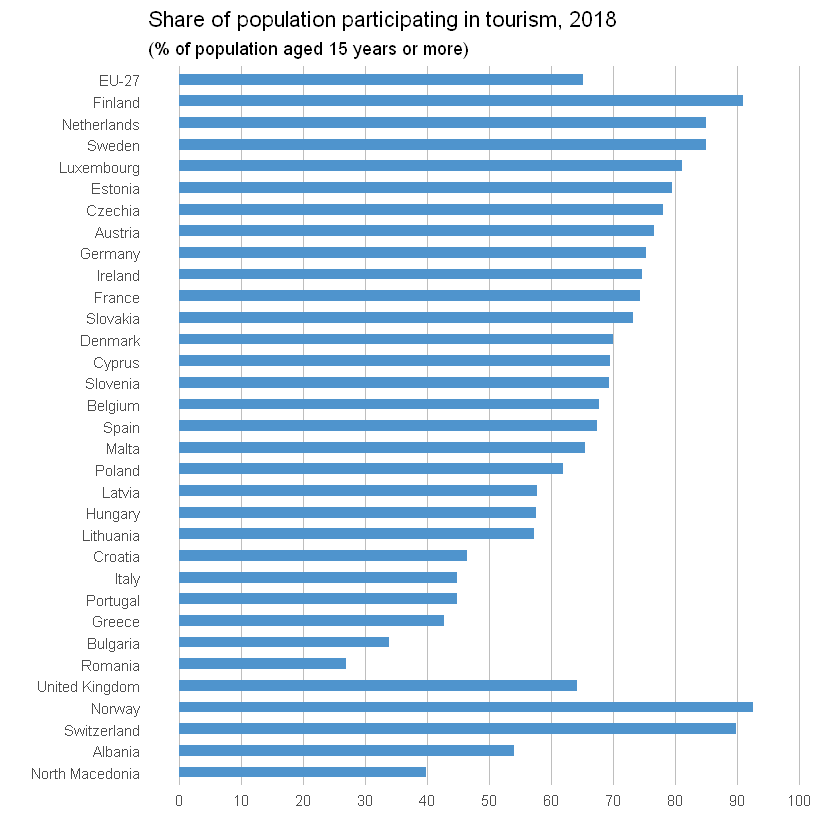

In [100]:
ggplot(data_tab2_part5, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
            ggtitle("Share of population participating in tourism, 2018",
                   subtitle="(% of population aged 15 years or more)") +
            coord_flip()+
            scale_x_discrete(limits = rev(levels(data_tab2_part5$geo)),
                             labels = c("North Macedonia", "Albania", "Switzerland", "Norway", "United Kingdom", 
                                        "Romania", "Bulgaria", "Greece", "Portugal", "Italy", "Croatia", "Lithuania", 
                                        "Hungary", "Latvia", "Poland", "Malta", "Spain", "Belgium", "Slovenia", "Cyprus", 
                                        "Denmark", "Slovakia", "France", "Ireland", "Germany", "Austria", "Czechia", 
                                        "Estonia", "Luxembourg", "Sweden", "Netherlands", "Finland", "EU-27")) +
            ylab(" ") +
            xlab(" ") +
            theme(panel.grid.major.x = element_line(color="grey"),
                  panel.background = element_rect(fill = NA),
                  axis.line = element_line(colour = "white"),
                  axis.ticks = element_line(colour= "white")) 

## Nights spent abroad by EU-27 residents: Luxembourg leads in nights per inhabitant

### create figure 6

#### First step:
- load the data `data_fig6`
- again we add a year-column

In [101]:
data_fig6 <- get_eurostat(id="tour_dem_tntot")

data_fig6$year <- as.integer(substr(data_fig6$time,1,4))

Table tour_dem_tntot cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/tour_dem_tntot_date_code_TF.rds


Create a new contry vector `countr_fig6` and exclude the countries, which need data from 2017. Build the subset `data_fig6_subs`

In [102]:
countr_fig6 <- countr <- c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","IE","CY","SE","HU","DK","SI",
                           "MT","FI","SK","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME","RS","MK","XK")
data_fig6_subs <- subset(data_fig6, 
                    data_fig6$geo %in% countr_fig6 & 
                    data_fig6$year==2018 &
                    data_fig6$purpose=="TOTAL" &
                    data_fig6$duration=="N_GE1"&
                    data_fig6$unit=="NR"&
                    data_fig6$partner=="OUT")
data_fig6_subs <- data_fig6_subs[,c(5,7)]

For Poland (`countr_fig6_2`) we need data from 2017. Build the subset `data_fig6_subs2`

In [103]:
countr_fig6_2 <- c("PL","RO")
data_fig6_subs2 <- subset(data_fig6, 
                    data_fig6$geo %in% countr_fig6_2 & 
                    data_fig6$year==2017 &
                    data_fig6$purpose=="TOTAL" &
                    data_fig6$duration=="N_GE1"&
                    data_fig6$unit=="NR"&
                    data_fig6$partner=="OUT")
data_fig6_subs2 <- data_fig6_subs2[,c(5,7)]

Match the two calculated subsets in `data_fig6_subs`

In [104]:
data_fig6_subs <- rbind(data_fig6_subs,data_fig6_subs2)

head(data_fig6_subs)

geo,values
<fct>,<dbl>
AT,74626464
BE,104276180
BG,6397986
CH,118774558
CY,11955548
CZ,46994452


#### Second step:
Calculate the EU-27 value by summing up
- create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of `data_fig6_subs` are within `EU_27`: `EU_27_prep4`
- by using the sapply-command we can calculate the sum: `tab_EU4`

In [105]:
EU_27_prep4 <- data_fig6_subs$geo %in% EU_27

tab_EU4 <- sapply(as.data.frame(data_fig6_subs[EU_27_prep4,2]),sum)

Add a column with the ratio we need for the pie chart
- build the ratio `tab_ratio2`
- just keep the EU-countries
- sort the values decreasing
- keep the top 9 countries (`tab_ratio_top9_2`) and summing up the others to "Rest of EU-27" (`tab_ratio_other_2_sum`) by using again the sapply command
- add the sum to the top 9: `tab_ratio_new_2`

In [106]:
tab_ratio2 <- cbind(data_fig6_subs,data_fig6_subs[2]/tab_EU4*100)

tab_ratio2 <- tab_ratio2[EU_27_prep4,]

tab_ratio2 <- tab_ratio2[order(tab_ratio2[,3], decreasing=T),]

tab_ratio_top9_2 <- tab_ratio2[1:9,]
tab_ratio_other_2 <- tab_ratio2[10:27,]
tab_ratio_other_2_sum <- sapply(as.data.frame(tab_ratio_other_2[,3]),sum)

tab_ratio_new_2 <- rbind(tab_ratio_top9_2[,c(1,3)], tab_ratio_other_2_sum)
tab_ratio_new_2

Warning message in `[<-.factor`(`*tmp*`, ri, value = 15.3142164698757):
"invalid factor level, NA generated"

,geo,values
,<fct>,<dbl>
7,DE,35.407430
13,FR,15.544253
22,NL,7.500622
25,SE,5.559875
11,ES,4.806601
28,PL,4.630022
17,IT,4.284631
2,BE,4.052285
1,AT,2.900065


Create the labels we need for the pie chart 
- round the values and put a "%" behind it: `label_pie2_1`
- create a vector with the needed country names: `label_pie2_2`
- combine the both created label parts: `label_pie2_3`

In [107]:
label_pie2_1 <- paste(round(tab_ratio_new_2$values,0), "%")

label_pie2_2 <- c("Germany","France","Netherlands","Sweden","Spain","Poland","Italy","Belgium",
                  "Austria","Rest of EU-27")

label_pie2_3 <- paste(label_pie2_2,"\n",label_pie2_1) #we can use a "/n" to get a line break

#### Third step:
Create variables for the position of the labels in the pie chart. Additionally change the colors in the vector `colors`, as you want.
 
Plot the pie chart

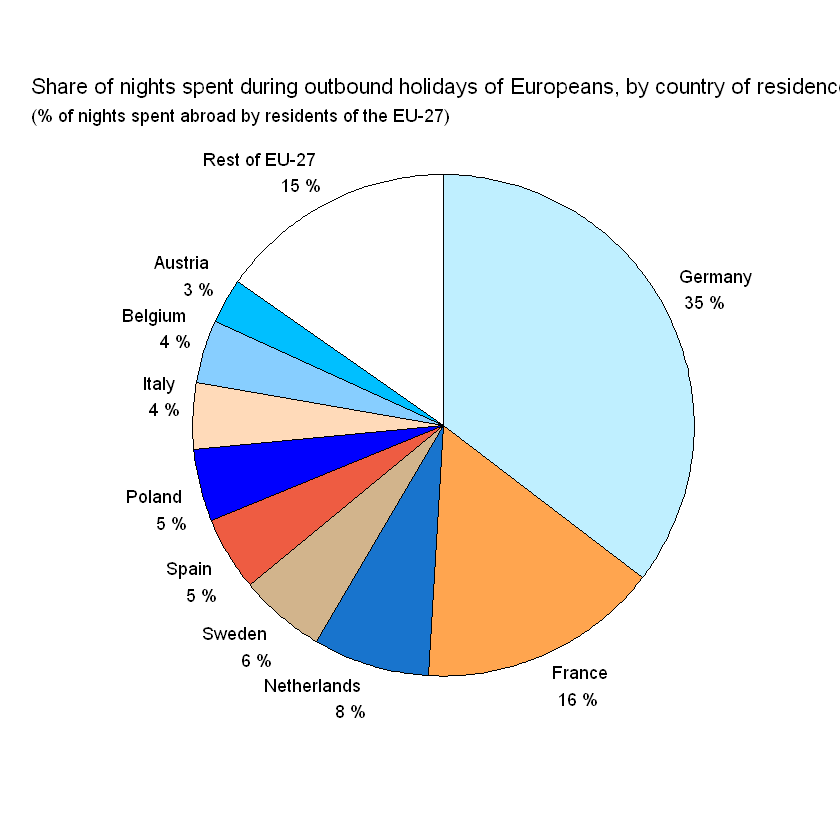

In [223]:
tab_ratio_new_2 <- tab_ratio_new_2 %>% 
  mutate(end = 2 * pi * cumsum(values)/sum(values),
         start = lag(end, default = 0),
         middle = 0.5 * (start + end),
         hjust = ifelse(middle > pi, 1, 0),
         vjust = ifelse(middle < pi/2 | middle > 3 * pi/2, 0, 1))

colors <- c("deepskyblue1","skyblue1","lightblue1","tomato2","tan1","peachpuff1","dodgerblue3","blue","tan")

ggplot(tab_ratio_new_2) + 
  geom_arc_bar(aes(x0 = 0, y0 = 0, r0 = 0, r = 1,
                   start = start, end = end, fill = geo)) +
  geom_text(aes(x = 1.05 * sin(middle), y = 1.05 * cos(middle), label = label_pie2_3,
                hjust = hjust, vjust = vjust)) +
  scale_fill_manual(values=colors) +
  coord_fixed() +
  scale_x_continuous(limits = c(-1.5, 1.4),        #Adjust so labels are not cut off
                     name = "", breaks = NULL, labels = NULL) +
  scale_y_continuous(limits = c(-1.15, 1.05),      #Adjust so labels are not cut off
                     name = "", breaks = NULL, labels = NULL) +
  ylab(" ") +
  xlab(" ") +
  theme_classic() + 
  theme(legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid  = element_blank()) +
  ggtitle("Share of nights spent during outbound holidays of Europeans, by country of residence of the tourist, 2018",
         subtitle="(% of nights spent abroad by residents of the EU-27)")



### create figure 7

#### First step:
We need the number of population by people aged over 15 years.
- load the data: `data_fig7`
- add again a year-column
- create a new country vector: `countr_fig7`

In [109]:
data_fig7 <- get_eurostat(id="demo_pjanbroad")

data_fig7$year <- as.integer(substr(data_fig7$time,1,4))

countr_fig7 <- c("LU","SE","CY","NL","IE","DE","FI","EE","BE","AT","DK","SI","MT","FR","LT","SK",
                 "CZ","LV","HU","PL","HR","ES","IT","PT","BG","EL","RO","CH","NO")

Table demo_pjanbroad cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/demo_pjanbroad_date_code_TF.rds


Build the subset `data_fig7_subs`
- because we have per country several data points, we have to aggregate the data per country

In [110]:
data_fig7_subs <- subset(data_fig7, 
                    data_fig7$geo %in% countr_fig7 & 
                    data_fig7$year==2018 &
                    data_fig7$age %in% c("Y15-64","Y_GE65") &
                    data_fig7$sex=="T")
data_fig7_subs <- data_fig7_subs[,c(4,6)]

data_fig7_subs <- aggregate(data_fig7_subs$values, by = list(geo = data_fig7_subs$geo), FUN = sum)

Bring the countries in the order the graphik shows (we have to do this for both needed datasets, i.e. `data_fig7_subs` and `data_fig6_subs`).
- data_fig7_subs_2; data_fig6_subs_fig7 --> compare the countries: are they in the same order? then we can match
- match the two data frames and calculate the ratio in `data_fig7_final`

In [111]:
data_fig6_subs_fig7 <- data_fig6_subs[order(factor(data_fig6_subs$geo, levels= countr_fig7)),]
data_fig7_subs_2 <- data_fig7_subs[order(factor(data_fig7_subs$geo, levels= countr_fig7)),]

In [112]:
data_fig7_final <- cbind(data_fig6_subs_fig7,data_fig7_subs_2[,2])
data_fig7_final$ratio <- round(data_fig7_final[,2]/data_fig7_final[,3],1)

#### Second step:
Calculate the EU-27 value by summing up
- create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of `data_fig7_final` are within `EU_27`: `EU_27_prep5`
- by using the sapply-command we can calculate the sum: `tab_EU5` 
- calculate the ratio `tab_EU5_ratio` and match them to `tab_EU5_final` (at this stage we get the warning message, that one NA for "Eu-27" get generated: we solve this problem two steps later)

In [113]:
EU_27_prep5 <- data_fig7_final$geo %in% EU_27

tab_EU5 <- sapply(as.data.frame(data_fig7_final[EU_27_prep5,2:3]),sum)

tab_EU5_ratio <- round(tab_EU5[1]/tab_EU5[2],1)

tab_EU5_final <- c("EU-27",tab_EU5,tab_EU5_ratio)

- put the calculates EU values to the table above: `data_fig7_final`
- we have to convert the class, because we have to add "EU-27" and this only works by converting it from a factor first, then doing the change and re-convert it back

In [114]:
data_fig7_final <- rbind(tab_EU5_final,data_fig7_final)

data_fig7_final[,1] <- as.character(data_fig7_final[,1])
data_fig7_final[1,1] <- "EU-27"
data_fig7_final[,1] <- factor(data_fig7_final[,1])

head(data_fig7_final)

Warning message in `[<-.factor`(`*tmp*`, ri, value = "EU-27"):
"invalid factor level, NA generated"

,geo,values,"data_fig7_subs_2[, 2]",ratio
,<fct>,<chr>,<chr>,<chr>
1,EU-27,2573268471,378201085,6.8
2,LU,15819287,504883,31.3
3,SE,143070504,8325565,17.2
4,CY,11955548,723947,16.5
5,NL,193011133,14418460,13.4
6,IE,50197497,3823944,13.1


#### Third step:
- bring the country names in the order the graphik shows you can do this due to modify the levels of the variable "geo"
- to achieve that the y-axes in the chart is later in an ascending order, we have to convert the ratio-axes to numeric

Plot the bar chart

In [115]:
data_fig7_final$geo <- factor(data_fig7_final$geo,
                        levels = c("EU-27","LU","SE","CY","NL","IE","DE","FI","EE","BE","AT","DK","SI","MT","FR","LT",
                                   "SK","CZ","LV","HU","PL","HR","ES","IT","PT","BG","EL","RO","CH","NO"))

data_fig7_final$ratio <- as.numeric(as.character(data_fig7_final$ratio))

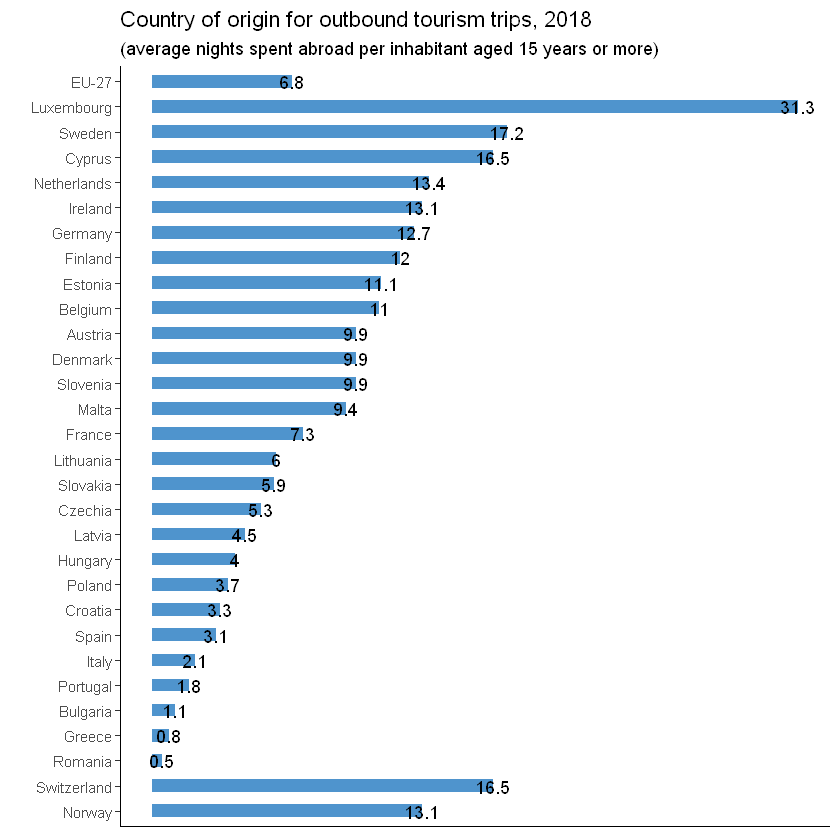

In [132]:
ggplot(data_fig7_final, aes(x=geo,y=ratio)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            ggtitle("Country of origin for outbound tourism trips, 2018",
                   subtitle = "(average nights spent abroad per inhabitant aged 15 years or more)") +
            coord_flip()+
            scale_x_discrete(limits = rev(levels(data_fig7_final$geo)),
                             labels = c("Norway", "Switzerland", "Romania", "Greece", "Bulgaria", "Portugal", "Italy", 
                                        "Spain", "Croatia", "Poland", "Hungary", "Latvia", "Czechia", "Slovakia", 
                                        "Lithuania", "France", "Malta", "Slovenia", "Denmark", "Austria",
                                        "Belgium", "Estonia", "Finland", "Germany", "Ireland", "Netherlands",
                                        "Cyprus", "Sweden", "Luxembourg","EU-27")) +
            ylab(" ") +
            xlab(" ") +
            theme(axis.title.x=element_blank(), #remove labels at x-axes
                  axis.text.x=element_blank(),
                  axis.ticks.x=element_blank()) +
                  geom_text(aes(label=ratio)) #add the ratio values after the bars

## Tourism expenditure: highest spending by German residents

### create table 3

#### First step:
- load the needed data `data_3` and add the year-column
- create a country-vector (in the order the table shows): `countr_tab3_1_1`

In [172]:
memory.limit(size=9999999999)

data_3 <- get_eurostat(id="bop_c6_a")
data_3$year <- as.integer(substr(data_3$time,1,4))

[1] 9999999999

Table bop_c6_a cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/bop_c6_a_date_code_TF.rds


In [173]:
countr_tab3_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PL","PT","RO","SI","SK","FI","SE","UK","IS","NO","CH","ME","MK","AL","RS","TR","BA","XK")

#### Second step:
We create first the columns for 2018 and afterwards the same for 2013
- due to we want to use a loop for getting the data for the three columns, we have to create a vector with the essential difference between the three columns (here: the variable "stk_flow"): `cred_deb_bal`
- create an empty data frame, which we can fill while running the loop: `data_tab3_part1`
    - we have 4 columns in the needed dataset: one country-column and three data-columns
    - and we have data for 38 countries and therefore 38 rows 
    
Build the subset `data_3_col1` within the loop
- the first column with the countries is the same for each of the three calculated datasets, therefore we can overwrite the country column in each intermediate step (we get of course a warning message)
- we assign the second column of each intermediate step to the three remaining columns of the empty data frame `data_tab3_part1` from above

In [174]:
cred_deb_bal <- c("CRE","DEB","BAL")

data_tab3_part1 <- as.data.frame(matrix(ncol = 4, nrow = 38))

In [175]:
for (i in 1:3) {
    
data_3_col1 <- subset(data_3, 
                    data_3$geo %in% countr_tab3_1_1 & 
                    data_3$year == 2018 &
                    data_3$currency =="MIO_EUR"&
                    data_3$bop_item== "SD" &
                    data_3$stk_flow == cred_deb_bal[i] &
                    data_3$partner == "WRL_REST")
data_3_col1 <- data_3_col1[,c(7,9)]

data_tab3_part1[,1] <- data_3_col1[,1]

data_tab3_part1[,1+i] <- data_3_col1[,2]
}

Bring the countries in the order the graphik shows.

Finally we have three of the seven columns filled with data.

In [177]:
data_tab3_part1 <- data_tab3_part1[order(factor(data_tab3_part1$V1, levels= countr_tab3_1_1)),]

head(data_tab3_part1)

,V1,V2,V3,V4
,<fct>,<dbl>,<dbl>,<dbl>
4,BE,7528.0,15654.0,-8126.0
5,BG,3808.2,1584.4,2223.8
8,CZ,6305.3,5055.5,1249.8
10,DK,7718.8,8926.6,-1207.7
9,DE,36390.0,80933.0,-44543.0
11,EE,1509.6,1244.8,264.8


#### Third step:
Now we create the 2013-columns and repeat the loop from above.
- due to we don't need the "balance column" we create at the beginning a vector with only 2 elements: `cred_deb_bal2`
- Albania, Portugal and Norway have no data for 2013, therefore we just need 35 rows in `data_tab3_part2` and assign NA after the loop in `data_3_col2_1`
- create a country-vector (in the order the table shows), exclude the countries with NA: `countr_tab3_1_2`

Build the subset `data_3_col2` within the loop and match the loop's result afterwards with the NAs of the three countries (`data_tab3_part2`).


In [178]:
cred_deb_bal2 <- c("CRE","DEB")

data_tab3_part2 <- as.data.frame(matrix(ncol = 3, nrow = 35))

countr_tab3_1_2 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PL","RO","SI","SK","FI","SE","UK","IS","CH","ME","MK","RS","TR","BA","XK")

In [179]:
for (i in 1:2) {
    
data_3_col2 <- subset(data_3, 
                    data_3$geo %in% countr_tab3_1_2 & 
                    data_3$year == 2013 &
                    data_3$currency =="MIO_EUR"&
                    data_3$bop_item== "SD" &
                    data_3$stk_flow == cred_deb_bal2[i] &
                    data_3$partner == "WRL_REST")
data_3_col2 <- data_3_col2[,c(7,9)]

data_tab3_part2[,1] <- data_3_col2[,1]

data_tab3_part2[,1+i] <- data_3_col2[,2]

}

In [180]:
data_3_col2_1 <- data.frame( V1=c("AL","PT","NO"),
                             V2=c(NA,NA,NA), 
                             V3=c(NA,NA,NA))

data_tab3_part2 <- rbind(data_tab3_part2,data_3_col2_1)

Bring the countries in the order the graphik shows.

Finally we have two further of the seven columns filled with data.

In [181]:
data_tab3_part2 <- data_tab3_part2[order(factor(data_tab3_part2$V1, levels= countr_tab3_1_1)),]

head(data_tab3_part2)

,V1,V2,V3
,<fct>,<dbl>,<dbl>
3,BE,10074.0,16692.0
4,BG,2890.8,840.0
7,CZ,5303.1,3493.8
9,DK,5385.1,7584.1
8,DE,31081.0,68793.0
10,EE,1255.8,802.8


#### Fourth step:
Calculate the "relative to GDP"-column.
- therefore first we have to load the dataset to receive the GDPs per country: `data_4`
- create a country-vector (in the order the table shows), exclude the countries with NA: `countr_tab3_2_1`
- Norway has no data, therefore we assign NA: `data_4_col3_2`

Build the subset `data_4_col3_1` and match the result afterwards with the NA of Norway to `data_tab3_part3`

In [182]:
data_4 <- get_eurostat(id="nama_10_gdp")
data_4$year <- as.integer(substr(data_4$time,1,4))

Reading cache file C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/nama_10_gdp_date_code_TF.rds
Table  nama_10_gdp  read from cache file:  C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/nama_10_gdp_date_code_TF.rds


In [183]:
countr_tab3_2_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PL","PT","RO","SI","SK","FI","SE","UK","IS","CH","ME","MK","AL","RS","TR","BA","XK")
    
data_4_col3_1 <- subset(data_4, 
                    data_4$geo %in% countr_tab3_2_1 & 
                    data_4$year == 2018 &
                    data_4$na_item == "B1GQ" &
                    data_4$unit == "CP_MEUR")
data_4_col3_1 <- data_4_col3_1[,c(3,5)]

data_4_col3_2 <- data.frame( geo= "NO", values= NA)

In [184]:
data_tab3_part3 <- rbind(data_4_col3_1,data_4_col3_2)

Bring the countries in the order the graphik shows.

In [185]:
data_tab3_part3 <- data_tab3_part3[order(factor(data_tab3_part3$geo, levels= countr_tab3_1_1)),]

head(data_tab3_part3)

geo,values
<fct>,<dbl>
BE,460419.4
BG,56111.8
CZ,210892.7
DK,302361.1
DE,3356410.0
EE,25937.6


Now we have to calculate the ratio.
- therefore we have to devide the 2018 data from above through the GDP-column calculated just now (`col4_1`,`col4_2`)

In [186]:
col4_1 <- data_tab3_part1[,2]/data_tab3_part3[,2]*100
col4_2 <- data_tab3_part1[,3]/data_tab3_part3[,2]*100

head(col4_1)
head(col4_2)

,values
,<dbl>
1,1.635031
2,6.786808
3,2.989814
4,2.552842
5,1.084194
6,5.820122


,values
,<dbl>
1,3.399944
2,2.823649
3,2.397191
4,2.952298
5,2.411297
6,4.799210


#### Fifth step:
- create column with the names of the countries, this will be the first column of the complete table 3: `countr_names2`
- finally put the calculated columns all together and round them correspondingly: `table3`
- give the columns the correct names

In [187]:
countr_names2 <- c("Belgium","Bulgaria","Czechia","Denmark","Germany","Estonia", "Ireland", "Greece", "Spain", "France", 
                  "Croatia", "Italy", "Cyprus", "Latvia", "Lithuania", "Luxembourg", "Hungary", "Malta", "Netherlands", 
                  "Austria", "Poland", "Portugal", "Romania", "Slovenia", "Slovakia", "Finland", "Sweden",
                 "United Kingdom","Iceland","Norway", "Switzerland","Montenegro","North Macedonia","Albania",
                  "Serbia","Turkey","Bosnia and Herzegovina","Kosovo")

In [188]:
table3 <- cbind(countr_names2,
                round(data_tab3_part2[,2],0),
                round(data_tab3_part1[,2],0),
                round(col4_1,1),
                round(data_tab3_part2[,3],0),
                round(data_tab3_part1[,3],0),
                round(col4_2,1),
                round(data_tab3_part1[,4],0))

In [189]:
names(table3) <- c("",
                        "Receipts (million EUR) 2013", 
                        "Receipts (million EUR) 2018",
                        "Relative to GDP 2018 (%)",
                        "Expenditure (million EUR) 2013",
                        "Expenditure (million EUR) 2018",
                        "Relative to GDP 2018 (%)",
                        "Balance (million EUR) 2018")
head(table3)

,,Receipts (million EUR) 2013,Receipts (million EUR) 2018,Relative to GDP 2018 (%),Expenditure (million EUR) 2013,Expenditure (million EUR) 2018,Relative to GDP 2018 (%),Balance (million EUR) 2018
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Belgium,10074,7528,1.6,16692,15654,3.4,-8126
2,Bulgaria,2891,3808,6.8,840,1584,2.8,2224
3,Czechia,5303,6305,3.0,3494,5056,2.4,1250
4,Denmark,5385,7719,2.6,7584,8927,3.0,-1208
5,Germany,31081,36390,1.1,68793,80933,2.4,-44543
6,Estonia,1256,1510,5.8,803,1245,4.8,265


#### Sixth step:
We need additionally the values for the EU
- load the needed data `data_5` and add the year-column

In [162]:
data_5 <- get_eurostat(id="bop_eu6_q",time_format = "raw")

Table bop_eu6_q cached at C:\Users\sarah\AppData\Local\Temp\Rtmp0oFI1n/eurostat/bop_eu6_q_raw_code_TF.rds


We create first the columns for 2018 and afterwards the same for 2013
- we will do exactly the same like for the several countries above

In [190]:
cred_deb_bal <- c("CRE","DEB","BAL")

data_tab3_part4 <- as.data.frame(matrix(ncol = 3, nrow = 1))

In [191]:
for (i in 1:3) {
    
data_5_col1 <- subset(data_5, 
                    data_5$geo == "EU27_2020" & 
                    data_5$time == 2018 &
                    data_5$currency =="MIO_EUR"&
                    data_5$bop_item== "SD" &
                    data_5$stk_flow == cred_deb_bal[i] &
                    data_5$partner == "EXT_EU27_2020")
data_5_col1 <- data_5_col1[,10]

data_tab3_part4[,i] <- data_5_col1

}

data_tab3_part4

V1,V2,V3
<dbl>,<dbl>,<dbl>
156587,109167.3,47419.7


Now we create the 2013-columns and repeat the loop from above.

In [192]:
cred_deb_bal2 <- c("CRE","DEB")

data_tab3_part5 <- as.data.frame(matrix(ncol = 2, nrow = 1))

In [193]:
for (i in 1:2) {
    
data_5_col2 <- subset(data_5, 
                    data_5$geo == "EU27_2020" & 
                    data_5$time == 2013 &
                    data_5$currency =="MIO_EUR"&
                    data_5$bop_item== "SD" &
                    data_5$stk_flow == cred_deb_bal[i] &
                    data_5$partner == "EXT_EU27_2020")
data_5_col2 <- data_5_col2[,10]

data_tab3_part5[,i] <- data_5_col2

}

data_tab3_part5

V1,V2
<dbl>,<dbl>
126010.7,86737.8


Calculate the "relative to GDP"-column
- we can use the dataset `data_4` to receive the GDPs per country
- now we have to calculate the ratio: therefore we have to devide the 2018 data from above (`data_tab3_part4`) through the GDP-column calculated just now (`data_5_col3`): `data_5_col4_1`, `data_5_col4_2`

In [194]:
data_5_col3 <- subset(data_4, 
                    data_4$geo == "EU27_2020" & 
                    data_4$year == 2018 &
                    data_4$na_item == "B1GQ"&
                    data_4$unit == "CP_MEUR")
data_5_col3 <- data_5_col3[,5]

In [195]:
data_5_col4_1 <- data_tab3_part4[,1]/data_5_col3*100
data_5_col4_2 <- data_tab3_part4[,2]/data_5_col3*100
data_5_col4_1
data_5_col4_2

values
<dbl>
1.158367


values
<dbl>
0.8075755


Finally put the calculated columns all together and round them correspondingly: `table3_EU`

Give the columns the correct names

In [196]:
countr_names3 <- c("EU-27")

table3_EU <- cbind(countr_names3,
                round(data_tab3_part5[,1],0),
                round(data_tab3_part4[,1],0),
                round(data_5_col4_1,1),
                round(data_tab3_part5[,2],0),
                round(data_tab3_part4[,2],0),
                round(data_5_col4_2,1),
                round(data_tab3_part4[,3],0))

names(table3_EU) <- c("",
                        "Receipts (million EUR) 2013", 
                        "Receipts (million EUR) 2018",
                        "Relative to GDP 2018 (%)",
                        "Expenditure (million EUR) 2013",
                        "Expenditure (million EUR) 2018",
                        "Relative to GDP 2018 (%)",
                        "Balance (million EUR) 2018")

table3_EU

,Receipts (million EUR) 2013,Receipts (million EUR) 2018,Relative to GDP 2018 (%),Expenditure (million EUR) 2013,Expenditure (million EUR) 2018,Relative to GDP 2018 (%),Balance (million EUR) 2018
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EU-27,126011,156587,1.2,86738,109167,0.8,47420


#### Seventh step:
Add the EU values (`table3_EU`) to `table3`: `table3_final`

In [197]:
table3_final <- rbind(table3_EU,table3)

as.matrix(table3_final)

,Receipts (million EUR) 2013,Receipts (million EUR) 2018,Relative to GDP 2018 (%),Expenditure (million EUR) 2013,Expenditure (million EUR) 2018,Relative to GDP 2018 (%),Balance (million EUR) 2018
EU-27,126011,156587,1.2,86738,109167,0.8,47420
Belgium,10074,7528,1.6,16692,15654,3.4,-8126
Bulgaria,2891,3808,6.8,840,1584,2.8,2224
Czechia,5303,6305,3.0,3494,5056,2.4,1250
Denmark,5385,7719,2.6,7584,8927,3.0,-1208
Germany,31081,36390,1.1,68793,80933,2.4,-44543
Estonia,1256,1510,5.8,803,1245,4.8,265
Ireland,3370,5760,1.8,4669,6399,2.0,-639
Greece,12152,16086,9.0,1835,2191,1.2,13895
Spain,51589,69168,5.7,12359,22396,1.9,46772
